# Predicting house prices in Iowa

## 1. Import libraries and dataframe.

In [119]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import os
import matplotlib 
from matplotlib import pyplot as plt
import math

In [120]:
# Import dataframe
os.chdir('C:/Users/Guillermo/Desktop/ESTUDIOS/Data Science Bootcamp/Projects/3. Machine Learning/Data')
df = pd.read_csv('train.csv')

## 2. Data Preprocessing

### 2.1 Split dataframe

#### Split the dataframe between a training and a testing dataframes in order to be able to evaluate our predictions.

In [121]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.loc[:,df.columns != 'SalePrice'], df['SalePrice'], test_size=0.2, random_state = 5)

### 2.2 Missing values

#### In a first exploration we check the number of rows with missing values and the total number of missing values in the training set. This reveals a high number of missing values spread over several variables. Especially, few variables have a high number of missing values. 

#### In order to have a visual representation a plot with the proportion of missing values per variable in the training set is created below.

The number of missing values in the training set is 5568.
The number of rows with missing values in the training set is 1168.


Text(0, 0.5, 'Variables')

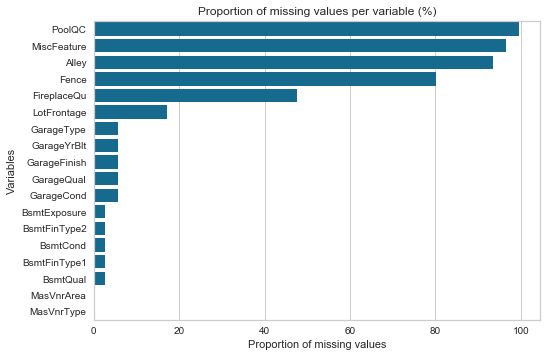

In [122]:
# Total number of missing values in the training set
print('The number of missing values in the training set is {}.'.format(x_train.isna().sum().sum()))

# Total number of rows with missing values. 
print('The number of rows with missing values in the training set is {}.'.format(x_train.shape[0] - x_train.dropna().shape[0]))

# Overview of missing values per variable
df1 = pd.DataFrame(round(((x_train.isna().sum())/x_train.shape[0])*100,2)).reset_index()
df1.rename(columns = {'index':'variables', 0:'missing_values'}, inplace = True)
df1 = df1[df1['missing_values'] > 0].sort_values(ascending = False, by = 'missing_values')
sns.barplot(x = 'missing_values', y = 'variables', data = df1, color = 'b')
plt.title('Proportion of missing values per variable (%)', loc = 'center')
plt.xlabel('Proportion of missing values')
plt.ylabel('Variables')


#### Now, we check the number of rows with missing values and the total number of missing values in the testing set. Again, this reveals a high number of missing values spread over several variables. In addition, we can see that one variable, Electrical, has only one missing value and that it fell in the testing set when the split was done. Therefore, there is an additional feature we have to impute in the testing set in comparison to the training set. 

#### Again, in order to have a visually representation a plot with the proportion of missing values per variable in the testing set is created.

The number of missing values in the testing set is 1397.
The number of rows with missing values in the testing set is 292.


Text(0, 0.5, 'Variables')

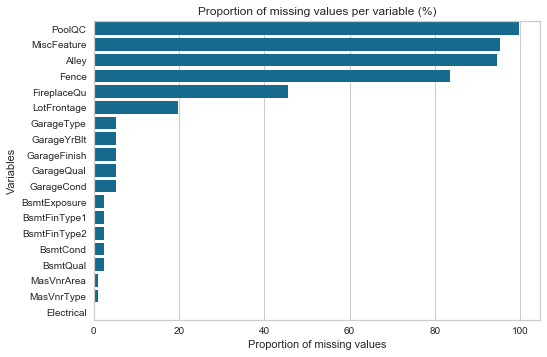

In [123]:
# Total number of missing values in the testing set
print('The number of missing values in the testing set is {}.'.format(x_test.isna().sum().sum()))

# Total number of rows with missing values. 
print('The number of rows with missing values in the testing set is {}.'.format(x_test.shape[0] - x_test.dropna().shape[0]))

# Overview of missing values per variable
df1 = pd.DataFrame(round(((x_test.isna().sum())/x_test.shape[0])*100,2)).reset_index()
df1.rename(columns = {'index':'variables', 0:'missing_values'}, inplace = True)
df1 = df1[df1['missing_values'] > 0].sort_values(ascending = False, by = 'missing_values')
sns.barplot(x = 'missing_values', y = 'variables', data = df1, color = 'b')
plt.title('Proportion of missing values per variable (%)', loc = 'center')
plt.xlabel('Proportion of missing values')
plt.ylabel('Variables')

#### We now proceed to explore each of the variables with missing values to decide what kind of solution we  should follow for each of them: 

#### 1. PoolQC: pool quality. Given the high proportion of missing values, we can infer that the meaning of this missing values is that those houses don´t have a pool. After checking that any of the pools is rated with quality 0, we assign 0 to missing values to indicate the abscence of a pool.
#### 2. MiscFeature: miscellaneous feature not covered in other categories. 'Shed' is the only one alternative value to NAs. We can impute None as refereing that there is no miscellaneous feature in those observations.
#### 3. Alley: type of alley access. Given the amount of missing data, it looks like those are houses with no alley. This can be confirmed in the documentation (data_description) provided by Kaggle. We can therefore imput the missing values as None to reflect this.
#### 4. Fence (categorial): Fence quality.Given the amount of missing data, it looks like those are houses with no fence. This can be confirmed in the documentation (data_description) provided by Kaggle. We can therefore imput the missing values as None to reflect this.
#### 5. FireplaceQu (categorial): fireplace quality.  Given the amount of missing data, it looks like those are houses with no fireplace. This can be confirmed in the documentation (data_description) provided by Kaggle. We can therefore imput the missing values as None to reflect this.
#### 6. GarageYrBlt (date): year the garage was built.Given that there are 5 different variables refering to the garage and that the same observations have missing values in those columns, it is safe to assume that missing values refer to houses with no garage. We impute for all the garage variables following this logic.
#### 7. GarageType (categorical): garage location (attchd, basment...)
#### 8. GarageQual (categorical): garage quality.
#### 9. GarageFinish (categorical): interior finish of the garage.
#### 10. GarageCond (categorical): garage condition.
#### 11. BsmtQual(categorical): height of the basement.Given that there are 5 different variables refering to the basement and that the same observations have missing values in those columns, it is safe to assume that missing values refer to houses with no basement. We impute for all the basement variables following this logic.
#### 12. BsmtFinType1 (categorical): quality of basament finished area.
#### 13. BsmtFinType2 (categorical): quality of basement finished area.
#### 14. BsmtExposure (categorical): walkout or garden level basement walls.
#### 15. BsmtCond (categorical):general condition of the basement.
#### 16. LotFrontage (numerical): linear feet of street connected to property. We assume that that LotFrontage will be similar within neighbors but may vary across them. Because of this reason, we impute with the median LotFrontage after grouping by neighborhood.
#### 17. MasVnrArea (numerical): masonry veneer area in square feet. We impute using the median.
#### 18. MasVnrType (categorical): masonry veneer type. We impute using the mode.

#### Following the explanation above, we impute on both the training and testing sets.

In [124]:
# We first impute the variables in which none is imputed in both the training and testing sets.
features_impute = ['MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageYrBlt', 'GarageType', 'GarageQual', 'GarageFinish', 
                   'GarageCond', 'BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'BsmtCond']

for feature in features_impute:
    x_train[feature] = x_train[feature].replace(np.nan, 'None') 
    x_test[feature] = x_test[feature].replace(np.nan, 'None') 

# We now impute PoolQC
x_train['PoolQC'] = x_train['PoolQC'].replace(np.nan, 0) 
x_test['PoolQC'] = x_test['PoolQC'].replace(np.nan, 0) 

# We now impute the features for which an imputation method was used:

# LotFrontage

x_train['LotFrontage'] = x_train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

for i in range(0, x_test.shape[0]):
    if x_test['Neighborhood'].iloc[i] in list(x_train['Neighborhood'].unique()):
        x_test['LotFrontage'].iloc[i] = x_train.groupby('Neighborhood')['LotFrontage'].median()[x_test['Neighborhood'].iloc[i]]
    else:
        x_test['LotFrontage'].iloc[i] = x_train['LotFrontage'].median()

# MasVnrArea
x_train['MasVnrArea'] = x_train['MasVnrArea'].fillna(x_train['MasVnrArea'].median())
x_test['MasVnrArea'] = x_test['MasVnrArea'].fillna(x_train['MasVnrArea'].median())

# MasVnrType
x_train['MasVnrType'] = x_train['MasVnrType'].apply(lambda x: str(x))
x_train['MasVnrType'] = x_train['MasVnrType'].apply(lambda x: x_train['MasVnrType'].mode() if x == 'nan' else x)

x_test['MasVnrType'] = x_test['MasVnrType'].apply(lambda x: str(x))
x_test['MasVnrType'] = x_test['MasVnrType'].apply(lambda x: x_train['MasVnrType'].mode() if x == 'nan' else x)

# Electrical(only missing value is in the testing set)
x_test['Electrical'] = x_test['Electrical'].apply(lambda x: str(x))
x_test['Electrical'] = x_test['Electrical'].apply(lambda x: x_train['Electrical'].mode() if x == 'nan' else x)

# CHECK IF THIS WAS DONE PROPERLY OR IF THIS MEDIANS AND MODES SHOULD HAVE BEEN LEARNED IN THE TRAINING DATAFRAME.


# Check if there are still missing values:

# Total number of missing values in the training dataframe
print('The number of missing values in the training set is {}.'.format(x_train.isna().sum().sum()))
# Total number of missing values in the training dataframe
print('The number of missing values in the testing set is {}.'.format(x_test.isna().sum().sum()))

C:\Users\Guillermo\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


The number of missing values in the training set is 0.
The number of missing values in the testing set is 0.


### 2.3 Feature engineering

### CHECK VARIANCE INFLATION FACTOR FOR MULTICOLLINEARITY

#### In order to check for multicollinearity among our numerical variables, me plot the correlation matrix of our features.

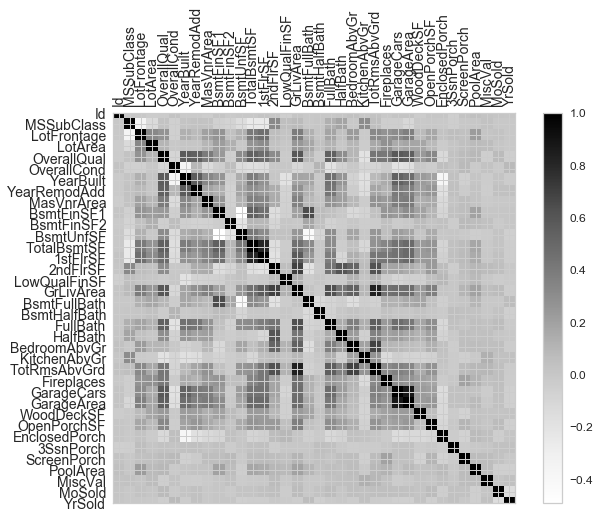

In [125]:
#### In order to check whether there may be multicollinearity in our model, me plot the correlation matrix of our features.
# Correlation matrix of all numeric variables
f = plt.figure(figsize=(10, 7))
plt.matshow(x_train.corr(), fignum=f.number)
plt.xticks(range(x_train.select_dtypes(['number']).shape[1]), x_train.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(x_train.select_dtypes(['number']).shape[1]), x_train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
#plt.title('Correlation Matrix', fontsize=16)

#### As we can see above, there are a number of variables that correlate with others. We identify the variables with the highest correlations and show them below. 

In [126]:
from scipy.stats import pearsonr
print(pearsonr(x_train['GarageCars'], x_train['GarageArea']))
print(pearsonr(x_train['GrLivArea'], x_train['TotRmsAbvGrd']))
print(pearsonr(x_train['TotalBsmtSF'], x_train['1stFlrSF']))
print(pearsonr(x_train['BedroomAbvGr'], x_train['TotRmsAbvGrd']))

(0.8780090189827533, 0.0)
(0.8277941633143427, 5.887339645542516e-295)
(0.8069948433216805, 5.675242673688655e-269)
(0.6880275813282115, 1.453766467759573e-164)


#### We now go on with our feature engineering. We perform the same feature engineering in both the training and testing sets independently. The features we engineer are:

#### Id: this feature is just an index so any correlations with the dependent or any other variables is random. Therefore, and in order to avoid multicollinearity, we drop it.

In [127]:
# Training set
x_train.drop(columns = ['Id'], inplace = True)

# Test set
x_test.drop(columns = ['Id'], inplace = True)

#### TotalSF: this new feature is created by adding up other variables that add up to the total square footage of each house/observation.

In [128]:
# Training set
x_train['TotalSF'] = x_train['TotalBsmtSF'] + x_train['1stFlrSF'] + x_train['2ndFlrSF']

# Test set
x_test['TotalSF']= x_test['TotalBsmtSF'] + x_test['1stFlrSF'] + x_test['2ndFlrSF']

#### Total bathrooms: this new feature includes the number of bathrooms in the house/observation. 

In [129]:
# Training set
x_train['Total_Bathrooms'] = (x_train['FullBath'] + (0.5 * x_train['HalfBath']) +
                               x_train['BsmtFullBath'] + (0.5 * x_train['BsmtHalfBath']))

# Test set
x_test['Total_Bathrooms'] = (x_test['FullBath'] + (0.5 * x_test['HalfBath']) +
                               x_test['BsmtFullBath'] + (0.5 * x_test['BsmtHalfBath']))

#### Total_porch_sf: new feature that includes the total square footage of the porch in each house/observation.

In [130]:
# Training set
x_train['Total_porch_sf'] = (x_train['OpenPorchSF'] + x_train['3SsnPorch'] +
                              x_train['EnclosedPorch'] + x_train['ScreenPorch'] +
                              x_train['WoodDeckSF'])

# Test set
x_test['Total_porch_sf'] = (x_test['OpenPorchSF'] + x_test['3SsnPorch'] +
                              x_test['EnclosedPorch'] + x_test['ScreenPorch'] +
                              x_test['WoodDeckSF'])

#### YrBltAndRemod: this variable adds the year the house was remodeled to the house it was built. 

In [131]:
x_train['YrBltAndRemod'] = x_train['YearBuilt'] + x_train['YearRemodAdd']
x_test['YrBltAndRemod'] = x_test['YearBuilt'] + x_test['YearRemodAdd']

#### We create a series of dummy features that gathers information on whether any of the following are present in the house:
#### 1. haspool: whether there is a pool.
#### 2. has2ndfloor: whether there is a second floor.
#### 3. hasgarage: whether there is a garage.
#### 4. hasbsmt: whether there is a basement.
#### 5. hasfireplace: whether there is a fireplace.    

In [132]:
# Training set
x_train['haspool'] = x_train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
x_train['has2ndfloor'] = x_train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
x_train['hasgarage'] = x_train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
x_train['hasbsmt'] = x_train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
x_train['hasfireplace'] = x_train['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Test set
x_test['haspool'] = x_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
x_test['has2ndfloor'] = x_test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
x_test['hasgarage'] = x_test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
x_test['hasbsmt'] = x_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
x_test['hasfireplace'] = x_test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

#### We now drop the variable out of which the new featues were created.

In [133]:
# Training set
x_train.drop(columns = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'FullBath', 'HalfBath', 
                        'BsmtFullBath', 'BsmtHalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 
                        'ScreenPorch', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'PoolArea', '2ndFlrSF',
                       'GarageArea', 'Fireplaces', 'BedroomAbvGr'], inplace = True)

# Test set
x_test.drop(columns = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'FullBath', 'HalfBath', 
                        'BsmtFullBath', 'BsmtHalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 
                        'ScreenPorch', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'PoolArea', '2ndFlrSF',
                       'GarageArea', 'Fireplaces', 'BedroomAbvGr'], inplace = True)


# THINK OF ALSO EXLUCING 'GrLivArea'

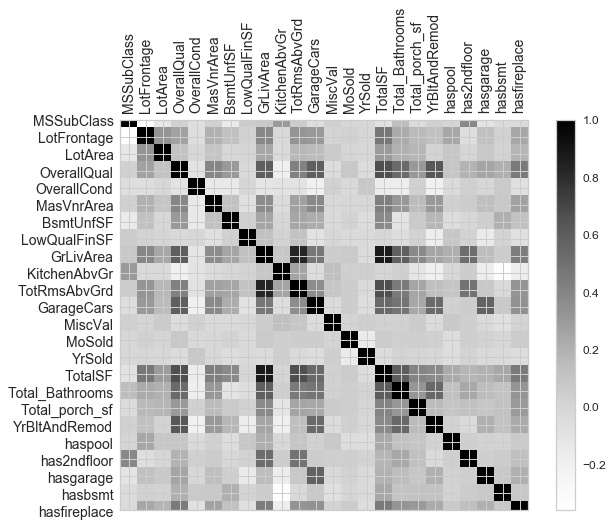

In [134]:
# Correlation matrix of all numeric variables
# Correlation matrix of all numeric variables
f = plt.figure(figsize=(10, 7))
plt.matshow(x_train.corr(), fignum=f.number)
plt.xticks(range(x_train.select_dtypes(['number']).shape[1]), x_train.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(x_train.select_dtypes(['number']).shape[1]), x_train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
#plt.title('Correlation Matrix', fontsize=16)

### 2.4 Outlier detection

#### We visualize SalePrice and different features and try to visualy detect outliers. We notice that there are concrete observations that could be outliers. 

The index of the outlier (maximum value) is 1298
The value of the outlier is 11752


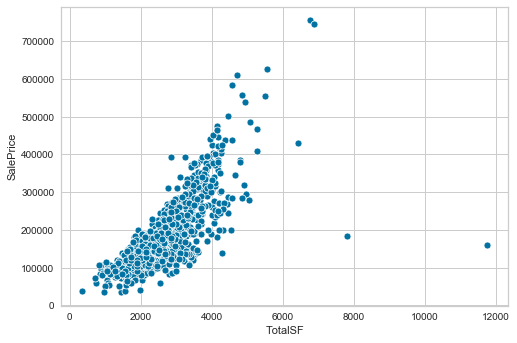

In [135]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
sns.scatterplot(x = 'TotalSF', y = 'SalePrice', data = df)
outlier_index = df.TotalSF.idxmax()
print('The index of the outlier (maximum value) is {}'.format(outlier_index))
print('The value of the outlier is {}'.format(df['TotalSF'].iloc[outlier_index, ]))

#### In order to detect outliers Cook´s distance is implemented. The observations that are signal out are appended to a list. We also try to identify outliers by checking whether they fall out of the inter quantile range (IQR). These outliers are also appended to a different list. Afterwards, we decide to drop the outliers that appear in both lists. The reason we follow this approach is that the Cook´s distance assumes an ordinary least square regression in order to identify outliers. Given that we also plan to implement different linear models (lasso and ridge in particular), it was decided to also use the IQR.

#### IQR outlier detection.

In [136]:
train = pd.concat([y_train, x_train], axis = 1)

# Define a function that will detect outliers according to the following boundaries:
def outlier_detection(feature): 
    sorted(feature) 
    q1,q3 = np.percentile(feature , [25,75]) 
    IQR = q3 - q1 
    lower_range = q1 - (3 * IQR) 
    upper_range = q3 + (3 * IQR) 
    return lower_range,upper_range

# Apply the function above to all numerical variables in the dataframe. Outliers found for every variable will be stored
# in a list and then append it to a nested list that contains all of the outlier´s indexes (so one list per variable within
# the nested list).
num_features = train.select_dtypes(include = ['number']).columns
outliers = {}
list_outliers = []
for feature in num_features:
    outlier_detection(train[feature])
    lower_range, upper_range = outlier_detection(train[feature])
    overall_qual_drop = train[(train[feature] < lower_range) | (train[feature] > upper_range)]
    outliers[feature] = list(overall_qual_drop.index)
    list_outliers.append(list(overall_qual_drop.index))

# Flatten the nested list so that we have a list with all the outliers´ indexes detected for each variable.
flat_list = []
for sublist in list_outliers:
    for item in sublist:
        flat_list.append(item)

# Create a dictinary with the counts of every outlier, so that we know how many times a single observation has been 
# classified as an outlier. We then sort the dictionary by descending order.
repeated_outliers = {i: flat_list.count(i) for i in flat_list}
repeated_outliers = sorted(repeated_outliers.items(), key = lambda x: x[1], reverse = True)

# We plot the output:
print('Number of times an observation is classified as an outlier:')
print('  ')
print('Nº       Index')
for index, outliers in repeated_outliers:
    print('{}        {}'.format(outliers, index))

Number of times an observation is classified as an outlier:
  
Nº       Index
7        1298
6        1182
5        523
4        197
4        635
4        705
3        769
3        1011
3        520
3        921
3        39
3        17
3        1386
2        178
2        798
2        185
2        898
2        313
2        934
2        171
2        335
2        249
2        53
2        375
2        589
2        198
2        88
2        1009
2        125
2        1349
2        868
2        165
2        1232
2        1283
2        1450
2        634
2        984
2        48
2        1030
2        342
2        736
2        1090
2        942
2        894
2        1350
2        102
2        1412
2        1216
2        1230
2        897
2        778
2        78
2        250
2        392
2        99
2        1328
2        738
2        1179
1        440
1        803
1        1046
1        909
1        1127
1        1107
1        231
1        1190
1        848
1        706
1        1396
1        4

In [137]:
outlier_index = []
for i in range(0,6):
    outlier_index.append(repeated_outliers[i][0])
print('The outliers to be removed from the dataframe are {}'.format(outlier_index))

The outliers to be removed from the dataframe are [1298, 1182, 523, 197, 635, 705]


#### Cook´s distance outlier detection.

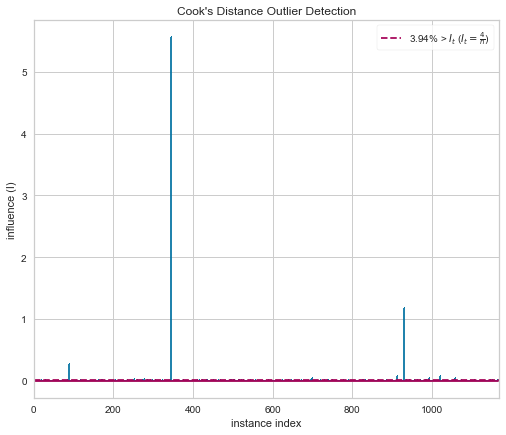

In [138]:
from yellowbrick.base import Visualizer
from yellowbrick.regressor import CooksDistance
visualizer = CooksDistance(size = (600, 500))
z = x_train.select_dtypes(include = ['int64', 'float64'])
visualizer.fit(z, y_train)
visualizer.poof()

In [139]:
outliers = visualizer.distance_ >= visualizer.influence_threshold_
outliers = list(outliers[outliers == True].index)

outlier = []
for i in range(1,len(outliers)):
    if outliers[i] in outlier_index:
               outlier.append(outliers[i])
            
x_train.drop(index = outliers, inplace = True)
y_train.drop(index = outliers, inplace = True) 

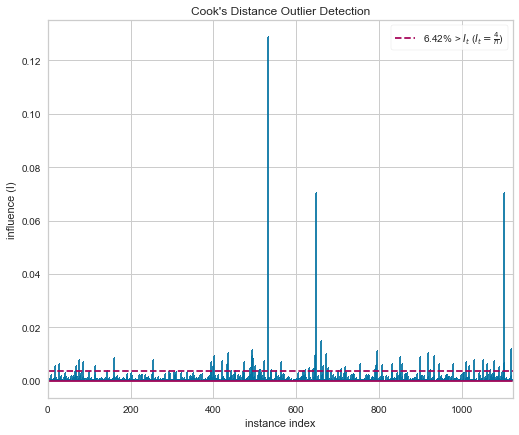

In [140]:
visualizer = CooksDistance(size = (600, 500))
z = x_train.select_dtypes(include = ['int64', 'float64'])
visualizer.fit(z, y_train)
visualizer.poof()

### 2.5 Yeo - Johnson transformation

#### Before implementing any transformation, we plot the distribution of our numerical variables:

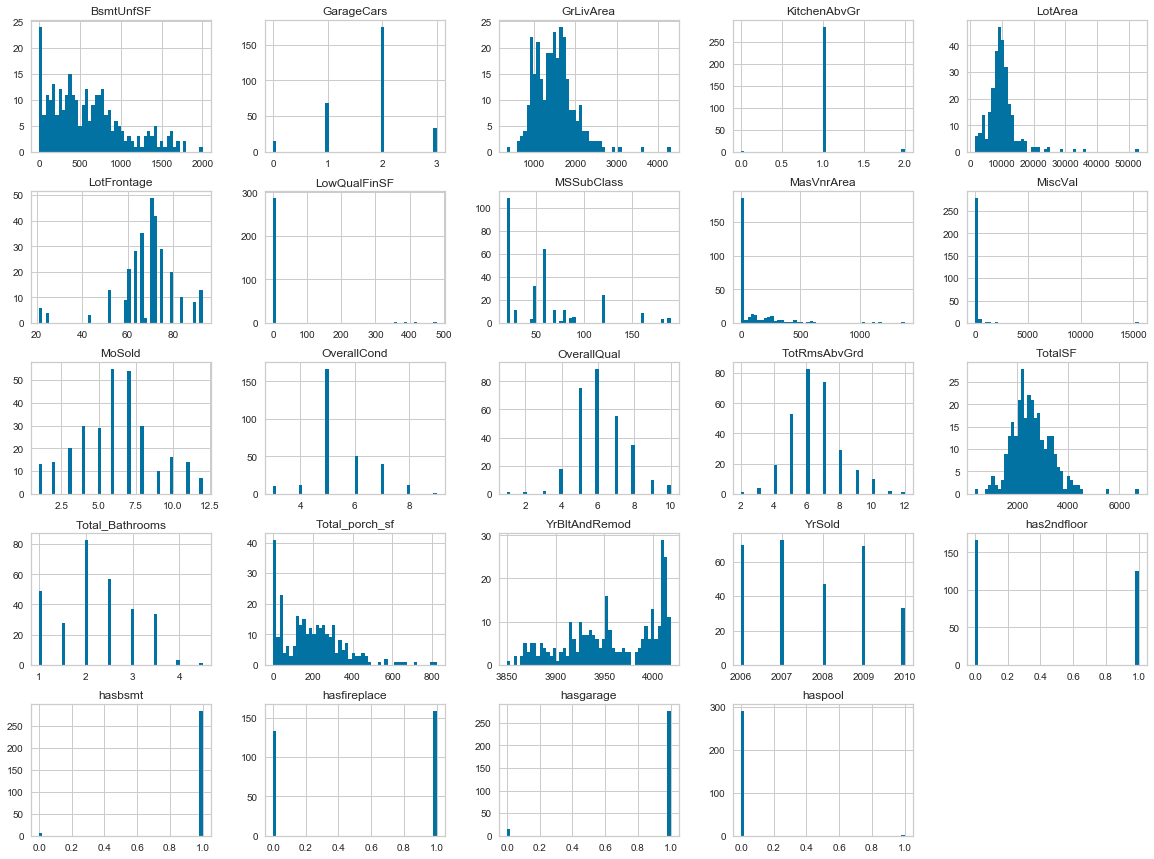

In [141]:
x_test.select_dtypes(include = ['int64', 'float64']).hist(bins = 50, figsize = (20,15))
plt.show()

#### We can see how the continuous numerical variables are right skewed. In order to correct for this, we try a transformation to normalize our features. There are three reasons why the yeo-johnson transformation is chosen: 
#### 1. Many of our features we have zero values and the box-cox transformation demands strictly positives values.
#### 2. Yeo-johnson tranformation allows to train in the training data and then apply to the testing data. Therefore, it keeps the rigour we need to keep to then realistically evaluate our model. 
#### 3. Yeo-johnson transformation also scales the data and centers it around zero.

In [142]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method = 'yeo-johnson')

for feature in ['BsmtUnfSF','LotArea','LotFrontage', 'MasVnrArea', 'MiscVal', 'MoSold', 'OverallCond', 
                'OverallQual', 'TotRmsAbvGrd','Total_porch_sf', 'YrBltAndRemod', 'YrSold', 'GrLivArea', 
                'TotalSF', 'Total_Bathrooms', 'MSSubClass']:
    x_train[feature] = pt.fit_transform(x_train[feature].to_numpy().reshape(-1,1))
    x_test[feature] = pt.transform(x_test[feature].to_numpy().reshape(-1,1))

#### We now check how the yeo-johnson transformation scaled and normalized our data. 

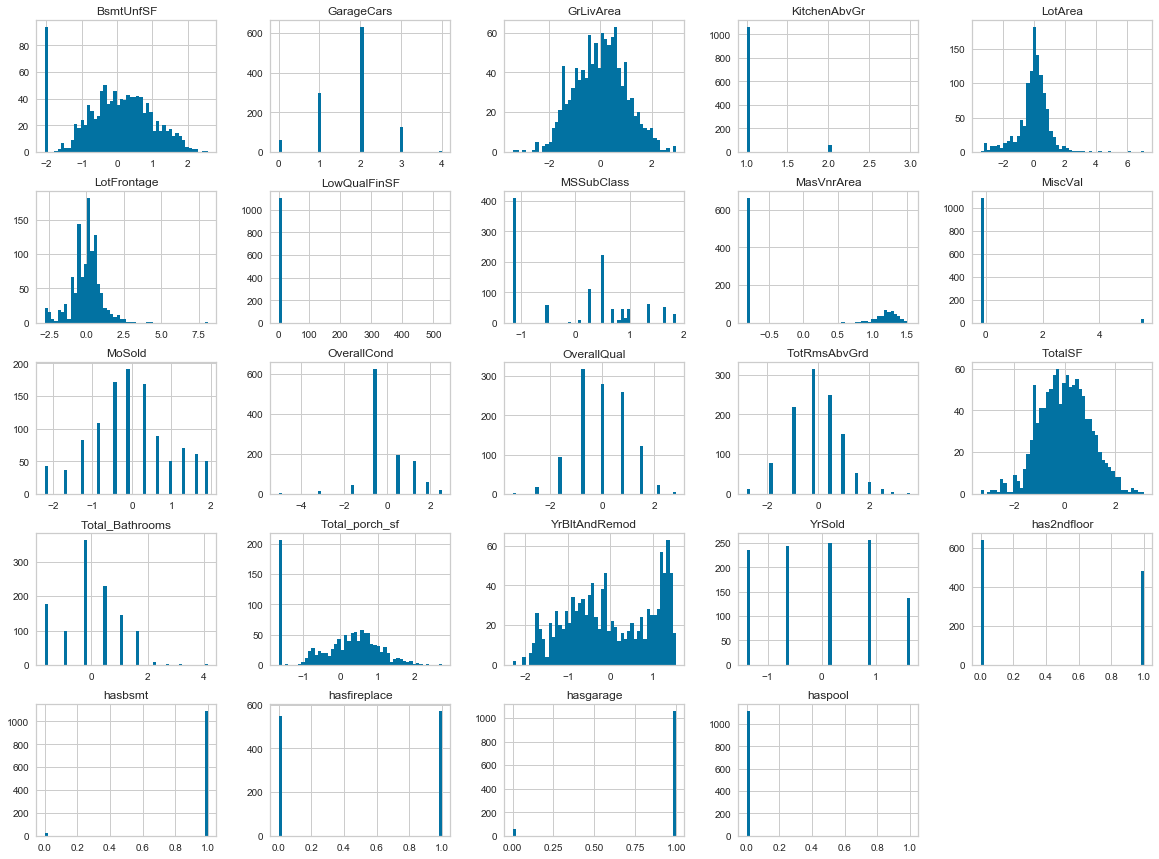

In [143]:
x_train.select_dtypes(include = ['int64', 'float64']).hist(bins = 50, figsize = (20,15))
plt.show()

### 2.6 Dummification

#### Dummify the categorical variables in the dataframe in order to make it adequate for the models we will implement. 

In [144]:
train_index = x_train.index
test_index = x_test.index


train = pd.concat([x_train, x_test], axis = 0)

for feature in train.select_dtypes(exclude = 'number'):
    train[feature] = train[feature].apply(lambda x: str(x))

x = pd.get_dummies(train, drop_first = True).copy()


x_train = x.loc[train_index]
x_test = x.loc[test_index]

### 2.7 Target variable´s logarithmic transformation 

#### The distribution of the dependent variables is right skewed. This will be a problem when implementing linear models. 

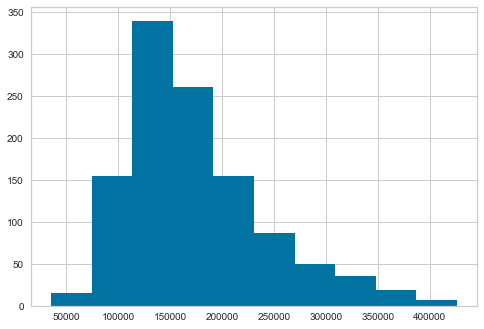

In [145]:
# Distribution of the dependent variable (y_train).
y_train.hist()
# HOW TO ELIMINATE THE SQUARES?

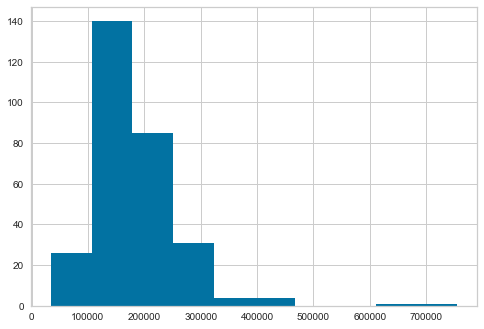

In [146]:
# Distribution of the dependent variable (y_train).
y_test.hist()

#### Because of this reason, we perform a logarithmic transformation on the dependent variable. We then check that it is now normally distributed in both the training and testing datasets.

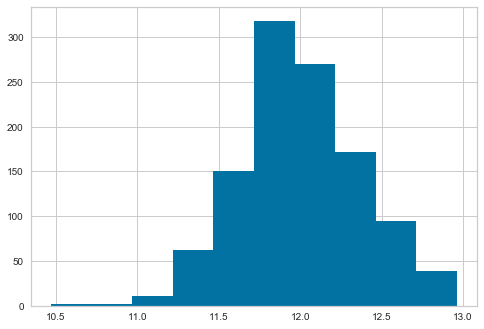

In [147]:
# We apply the logarithmic transformation.
y_train = y_train.apply(lambda x: np.log(x))

# We check the new dependent variable´s distribution.
y_train.hist() 
# IS IT BETTER FOR NON-LINEAR MODELS NOT TO HAVE THE LOG? 
# LOG SHOULD BE DONE BEFORE OR AFTER SCALING?
# ELIMINATE SQUARES.


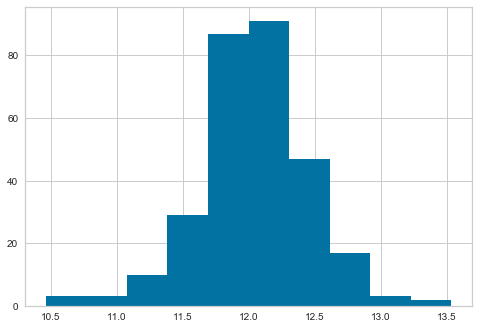

In [148]:
# We apply the logarithmic transformation.
y_test = y_test.apply(lambda x: np.log(x))

# We check the new dependent variable´s distribution.
y_test.hist() 

## 2.8 Principal component analysis

#### Principal component analysis was tried but was discarded because the performance of the linear models are not improved and interpretability is lost as the information provided by the variables is condensed in the principal componenets. This impedes looking at which features are most relevant from a pricing perspective, which can be valued from a business perspective.

In [149]:
# Find the optimal amount of principal components
#from sklearn.decomposition import PCA

#pca = PCA(random_state = 5)
#pca.fit(x_train)

#plt.plot(pca.explained_variance_, linewidth = 2)
#plt.xlabel('Components')
#plt.ylabel('Explained Variances')
#plt.show()
# The optimal amount is around 5


# Fit PCA with right amount of principal components
#from sklearn.decomposition import PCA

#pca = PCA(random_state = 5, n_components = 5)

#x_train = pd.DataFrame(pca.fit_transform(x_train), columns = ['p_component1', 'p_component2', 'p_component3', 'p_component4', 'p_component5'])
#x_test = pd.DataFrame(pca.transform(x_test), columns = ['p_component1', 'p_component2', 'p_component3', 'p_component4', 'p_component5'])


## 3. Multiple Linear Regression

In [150]:
#pip install yellowbrick

#### First linear model to try is multiple linear regression. We follow these steps:
#### 1. Implement the model and check how much of the variance in the model it explains (R-squared) in both the training and testing datasets. 
#### 2. Check whether the assumptions of linear regression (linearity, homoskedasticity, normally distributed residuals and abscence of multicollinearity) are fullfiled. 
#### 3. Generate a prediction using our model and comparing it to the testing dataset (y_test) to evaluate its accuracy.  

### 3.1. We begin by implementing the model as explained above:

In [151]:
from sklearn.linear_model import LinearRegression

# Implement the multiple linear regression model
ols = LinearRegression(fit_intercept = True) 
ols.fit(x_train, y_train)

# Check the model´s performance
print('Training set R-squared is {}'.format(ols.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(ols.score(x_test, y_test)))

Training set R-squared is 0.9569659155802756
Testing set R-squared is 0.9112498198756301


### 3.2 Now we move on to check the linear regression models assumptions:

#### 1. Homoskedasticity assumption. 

#### We run a bartlett test by splitting the residual´s array into two different arrays to test if they have the same variance (bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances).

#### We also plot the residuals plot to have a visual representation of the residuals distribution and check whether there is heteroskedasticity. 

The bartlett test´s statistics is 0.05638661312219746 and the p-value is 0.8123009900435725


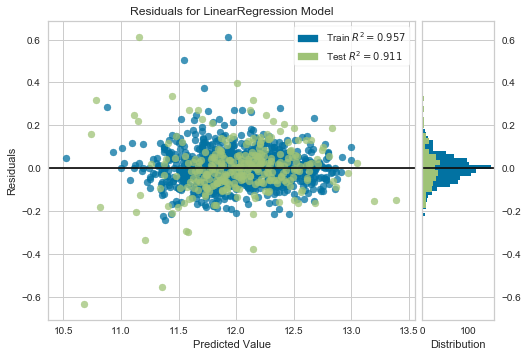

In [152]:
# 1. First linear regression assumption: homoskedasticity.

# Bartlett’s test
residuals = ols.predict(x_test) - y_test

split_array = np.split(residuals, 2)
sample1 = split_array[0]
sample2 = split_array[1]

from scipy import stats
bartlett = stats.bartlett(sample1, sample2)
print('The bartlett test´s statistics is {} and the p-value is {}'.format(bartlett[0], bartlett[1]))

# Plot residuals
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(ols)

# Fit the training data to the visualizer
visualizer.fit(x_train, y_train)  
# Evaluate the model on the test data
visualizer.score(x_test, y_test)  
# Finalize and render the figure
visualizer.show()

#### The plot allows us to check that there is not heteroskedasticity. In addition, the bartlett’s test p_value does not suffice to reject the null hypothesis (equal variances). Therefore, we can conclude that the homoskedasticity assumption holds. 

#### 2. Normality of the residuals assumption

#### In order to check normality a Q-Q plot is visualized below. Also, a battery of normality test are run: Jarque-Bera test, Shapiro-Wilk test, Anderson-Darling test and the Kolmogorov-Smirnov test.

Jarque_bera statistic is 407.4335147474946 and the p-value is 0.0
Shapiro-Wilk statistic is 0.9197090864181519 and the p-value is 2.051919051337947e-11
Anderson-Darling statistic is 4.645223435161256 and the p-values are [0.568 0.647 0.777 0.906 1.078]
Kolmogorov-Smirnov statistic is 0.3973207899006955 and the p-value is 4.3378417239772604e-42


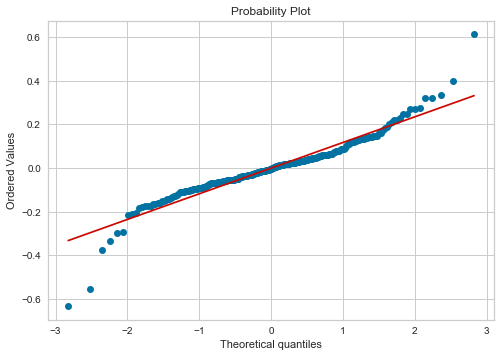

In [153]:
# Jarque_bera test
jb = stats.jarque_bera(residuals)
print('Jarque_bera statistic is {} and the p-value is {}'.format(jb[0], jb[1]))
# Shapiro-Wilk test
sw = stats.shapiro(residuals)
print('Shapiro-Wilk statistic is {} and the p-value is {}'.format(sw[0], sw[1]))
# Anderson-Darling test
ad = stats.anderson(residuals, dist = 'norm')
print('Anderson-Darling statistic is {} and the p-values are {}'.format(ad[0], ad[1]))
# Kolmogorov-Smirnov test
ks = stats.kstest(residuals, 'norm')
print('Kolmogorov-Smirnov statistic is {} and the p-value is {}'.format(ks[0], ks[1]))

# Plot Q-Q graph
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist = "norm", plot = pylab)
pylab.show()

#### The plot shows that the residuals don´t follow an exact normal distribution. The battery of tests confirm this result. The fact that the normality assumptions does not hold should make us skeptical of the reliability of the model. Part of the reason this is happening, and will also happen in different linear models, is the amount of zeros that we had in our variables that were not strictly normalize by the yeo-johnosn transformation. Because of these reasons, we will compare the predictions of the model against the y_test prices we are trying to predict. This allows an empirical comprobation. 

#### 3. Independence of the residuals assumption

#### Residuals should be independent. In order to test this we implement a Durbin-Watson test. This test assumes the following hypothesis:

#### Durbin-Watson test:

   #### H0 (null hypothesis): There is no correlation among the residuals.

   #### HA (alternative hypothesis): The residuals are autocorrelated.

   #### The test statistic is approximately equal to 2*(1-r) where r is the sample autocorrelation of the residuals. Thus, the test statistic will always be between 0 and 4 with the following interpretation:

   #### A test statistic of 2 indicates no serial correlation.
   #### The closer the test statistics is to 0, the more evidence of positive serial correlation.
   #### The closer the test statistics is to 4, the more evidence of negative serial correlation.

In [154]:
# Durbin Watson test for independent errors
from statsmodels.stats.stattools import durbin_watson

db = durbin_watson(residuals, axis = 0)

print('The Durbin_Watson statistics is {}'.format(db))

The Durbin_Watson statistics is 1.899956580764909


#### From the result above we can conclude that our residuals are independent. 

#### 4. Multicollinearity assumption 

#### There is some multicollinearity between some of the featues as we saw in the correlation matrix above. Because of this reason, we will also implement Lasso and Ridge regressions in order to take advantage of the possibility of regularization to control for multicollinearity.

### 3.3 Generate and evaluate the prediction

#### Once we have our model, we predict prices for the houses in the testing dataset. This output is a vector that can be compared with the actual testing dataset (y_test). This way, we can evaluate the accuracy of the predictions checking the MSE, RMSE and MAE. 

In [155]:
# Predict SalePrices with the model.
prediction = ols.predict(x_test)

# Check accuracy with MSE
from sklearn.metrics import mean_squared_error
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with the test dataset.
from sklearn.metrics import mean_absolute_error
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.014937903504280614
The root mean squared error (RMSE) is 0.12222071634661864
The mean absolute error (MAE) is 0.08406084156396074


## 4. Lasso Regression

#### As explained before, our multiple linear regression model suffers from multicollinearity. In order to solve this problem we move on to try regression models with regularization properties. In the first place, we try the lasso regression. The steps to follow are:
#### 1. We implement the lasso regression model and check the R-squared for the training and testing dataframes and the degree of regularization in the model. 
#### 2. We tune the hyperparameters using cross-validation and use them to fit a new model, thus trying to find the right balance between accuracy and variance of the model, avoiding over-fitting.
#### 3. Test linear models assumptions.
#### 4. Generate a prediction using our model and comparing it to the testing dataset (y_test) to evaluate its accuracy.  

### 4.1 Implement the lasso regression model

In [156]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(x_train, y_train)

# Check the model´s performance.
print('Training set R-squared is {}'.format(lasso.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(lasso.score(x_test, y_test)))
print('Amount of penalization is {}'.format(lasso.alpha))
# WOULD YOU PUT THIS TOGETHER OR PUT THE CHECK PERFORMANCE IN A DIFFERENT CELL? HOW TO BEST STRUCTURE THE CHUNKS? 
# Separate and leave markdown comment.

Training set R-squared is 0.0
Testing set R-squared is -0.0050984416696817645
Amount of penalization is 1.0


### 4.2 Tune the hyperparameters using cross-validation and fit a new model

In [157]:
from sklearn.linear_model import LassoCV
cv_lasso = LassoCV(n_alphas = 200, cv = 10, max_iter = 1000, fit_intercept = True) 
cv_lasso.fit(x_train, y_train)

# HOW AM I GETTING WORSE PERFORMANCE WITH CROSS-VALIDATION?

# Check Lasso´s performance and best parameters as outcomes of cross validation.
print('Training set R-squared is {}'.format(cv_lasso.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_lasso.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_lasso.alpha_))

Training set R-squared is 0.9294692043037703
Testing set R-squared is 0.921962787855616
Amount of penalization is 0.0009713318462895912


### 4.3 Test linear model assumptions

#### 1. Homoskedasticity assumption. 

#### We run a bartlett test by splitting the residual´s array into two different arrays to test if they have the same variance (bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances).

#### We also plot the residuals plot to have a visual representation of the residuals distribution and check whether there is heteroskedasticity. 

The bartlett test´s statistics is 7.342048937529434 and the p-value is 0.006736001882082477


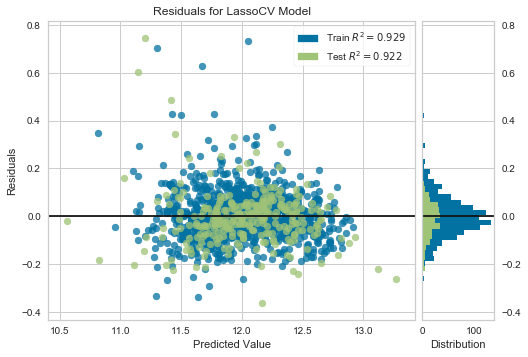

In [158]:
# Bartlett’s test
residuals = cv_lasso.predict(x_test) - y_test

split_array = np.split(residuals, 2)
sample1 = split_array[0]
sample2 = split_array[1]

import scipy.stats
bartlett = stats.bartlett(sample1, sample2)
print('The bartlett test´s statistics is {} and the p-value is {}'.format(bartlett[0], bartlett[1]))

# Plot residuals
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(cv_lasso)

# Fit the training data to the visualizer
visualizer.fit(x_train, y_train)  
# Evaluate the model on the test data
visualizer.score(x_test, y_test)  
# Finalize and render the figure
visualizer.show()

#### The plot allows us to check that there is not heteroskedasticity. In addition, the bartlett’s test p_value does not suffice to reject the null hypothesis (equal variances). Therefore, we can conclude that the homoskedasticity assumption holds. 

#### 2. Normality of the residuals assumption



#### In order to check normality a Q-Q plot is visualized below. Also, a battery of normality test are run: Jarque-Bera test, Shapiro-Wilk test, Anderson-Darling test and the Kolmogorov-Smirnov test.

Jarque_bera statistic is 1256.753548448938 and the p-value is 0.0
Shapiro-Wilk statistic is 0.8727228045463562 and the p-value is 7.934715811643272e-15
Anderson-Darling statistic is 6.200579977069026 and the p-values are [0.568 0.647 0.777 0.906 1.078]
Kolmogorov-Smirnov statistic is 0.3997798407004011 and the p-value is 1.2572680525514781e-42


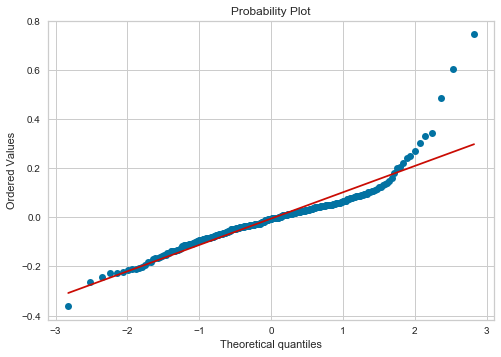

In [159]:
from scipy import stats
# Jarque_bera test
jb = stats.jarque_bera(residuals)
print('Jarque_bera statistic is {} and the p-value is {}'.format(jb[0], jb[1]))
# Shapiro-Wilk test
sw = stats.shapiro(residuals)
print('Shapiro-Wilk statistic is {} and the p-value is {}'.format(sw[0], sw[1]))
# Anderson-Darling test
ad = stats.anderson(residuals, dist = 'norm')
print('Anderson-Darling statistic is {} and the p-values are {}'.format(ad[0], ad[1]))
# Kolmogorov-Smirnov test
ks = stats.kstest(residuals, 'norm')
print('Kolmogorov-Smirnov statistic is {} and the p-value is {}'.format(ks[0], ks[1]))

# Plot Q-Q graph
stats.probplot(residuals, dist = "norm", plot = pylab)
pylab.show()

#### The plot shows that the residuals don´t follow an exact normal distribution. The battery of tests confirm this result. The fact that the normality assumptions does not hold should make us skeptical of the reliability of the model. Because of this reason, we will compare the predictions of the model against the y_test prices we are trying to predict. 

#### 3. Independence of the residuals assumption





#### Same as with the multiple linear regression model, a Durbin-Watson test is implemented to evaluate whether the residuals are indepentent.

In [160]:
db = durbin_watson(residuals, axis = 0)

print('The Durbin_Watson statistics is {}'.format(db))

The Durbin_Watson statistics is 1.924226207011367


#### From the result above we can conclude that our residuals are independent. 

### 4.4 Generate and evaluate the prediction

#### Once we have our model, we predict prices for the houses in the testing dataset. This results in a vector that can be compared with the actual testing dataset (y_test). We test the accuracy of the predictions calculating the mean absolute error.

In [161]:
# Predict SalePrices with the model.
prediction = cv_lasso.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.01313476032524457
The root mean squared error (RMSE) is 0.11460698200914536
The mean absolute error (MAE) is 0.07634561732058454


## 5. Ridge Regression

#### Ridge regression is another linear model that allows regularization. We follow the same steps as before when implementing lasso: 
#### 1. Implement the ridge regression model, check the R-squared for the training and testing dataframes and the degree of regularization in the model. 
#### 2. Tune the hyperparameters using cross-validation and use them to fit a new model.
#### 3. Evaluate wether the linear regression assumptions hold.
#### 4. Generate a prediction using our model and comparing it to the testing dataset (y_test) to evaluate its accuracy.  

### 5.1 Implement the ridge model

In [162]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(x_train, y_train)

# Check the model´s performance
print('Training set R-squared is {}'.format(ridge.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(ridge.score(x_test, y_test)))
print('Amount of penalization is {}'.format(ridge.alpha))

Training set R-squared is 0.95386647620738
Testing set R-squared is 0.9229943751991356
Amount of penalization is 1.0


### 5.2 Tune the hyperparameters using cross-validation

In [163]:
from sklearn.linear_model import RidgeCV
cv_ridge = RidgeCV(alphas = np.linspace(18, 19, 100), cv = 3, normalize = False, fit_intercept = True)
cv_ridge.fit(x_train, y_train)

# Check Ridge best parameters as outcomes of cross validation.
print('Training set R-squared is {}'.format(cv_ridge.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_ridge.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_ridge.alpha_))

Training set R-squared is 0.9407457919892735
Testing set R-squared is 0.9256037842621195
Amount of penalization is 18.04040404040404


### 5.3 Evaluate linear models assumptions

#### 1. Homoskedasticity assumption. 

#### We run a bartlett test by splitting the residual´s array into two different arrays to test if they have the same variance (bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances).

#### We also plot the residuals plot to have a visual representation of the residuals distribution and check whether there is heteroskedasticity. 

The bartlett test´s statistics is 6.440223318024228 and the p-value is 0.011156462035033931


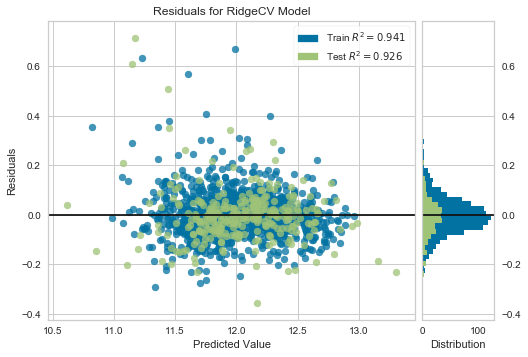

In [164]:
# Bartlett’s test
residuals = cv_ridge.predict(x_test) - y_test

split_array = np.split(residuals, 2)
sample1 = split_array[0]
sample2 = split_array[1]

import scipy.stats
bartlett = stats.bartlett(sample1, sample2)
print('The bartlett test´s statistics is {} and the p-value is {}'.format(bartlett[0], bartlett[1]))

# Plot residuals
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(cv_ridge)

# Fit the training data to the visualizer
visualizer.fit(x_train, y_train)  
# Evaluate the model on the test data
visualizer.score(x_test, y_test)  
# Finalize and render the figure
visualizer.show()                 

#### The plot allows us to check that there is not heteroskedasticity. In addition, the bartlett’s test p_value does not suffice to reject the null hypothesis (equal variances). Therefore, we can conclude that the homoskedasticity assumption holds. 




#### 2. Normality of the residuals assumption

#### In order to check normality a Q-Q plot is visualized below. Also, a battery of normality test are run: Jarque-Bera test, Shapiro-Wilk test, Anderson-Darling test and the Kolmogorov-Smirnov test.

Jarque_bera statistic is 1322.579185613187 and the p-value is 0.0
Shapiro-Wilk statistic is 0.8613927364349365 and the p-value is 1.633858263222173e-15
Anderson-Darling statistic is 7.334916023855669 and the p-values are [0.568 0.647 0.777 0.906 1.078]
Kolmogorov-Smirnov statistic is 0.4048334270805617 and the p-value is 9.590983990857345e-44


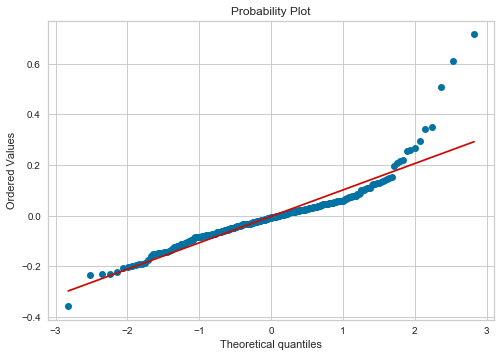

In [165]:
from scipy import stats
# Jarque_bera test
jb = stats.jarque_bera(residuals)
print('Jarque_bera statistic is {} and the p-value is {}'.format(jb[0], jb[1]))
# Shapiro-Wilk test
sw = stats.shapiro(residuals)
print('Shapiro-Wilk statistic is {} and the p-value is {}'.format(sw[0], sw[1]))
# Anderson-Darling test
ad = stats.anderson(residuals, dist = 'norm')
print('Anderson-Darling statistic is {} and the p-values are {}'.format(ad[0], ad[1]))
# Kolmogorov-Smirnov test
ks = stats.kstest(residuals, 'norm')
print('Kolmogorov-Smirnov statistic is {} and the p-value is {}'.format(ks[0], ks[1]))

# Plot Q-Q graph
stats.probplot(residuals, dist = "norm", plot = pylab)
pylab.show()

#### The plot shows that the residuals don´t follow an exact normal distribution. The battery of tests confirm this result. The fact that the normality assumptions does not hold should make us skeptical of the reliability of the model. Because of this reason, we will compare the predictions of the model against the y_test prices we are trying to predict. This allows an empirical comprobation. 


#### 3. Independence of the residuals assumption

#### Same as with the multiple linear regression model and the lasso model, a Durbin-Watson test is implemented to evaluate whether the residuals are indepentent.

In [166]:
db = durbin_watson(residuals, axis = 0)

print('The Durbin_Watson statistics is {}'.format(db))

The Durbin_Watson statistics is 1.8834268921332793


#### From the result above we can conclude that our residuals are independent. 

### 5.4 Generate and evaluate the prediction

#### Once we have our model, we predict prices for the houses in the testing dataset. This results in a vector that can be compared with the actual testing dataset (y_test). We test the accuracy of the predictions calculating the mean absolute error.

In [167]:
# Predict SalePrices with the model.
prediction = cv_ridge.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.01252192942277695
The root mean squared error (RMSE) is 0.11190142725978498
The mean absolute error (MAE) is 0.07323091734458329


## 6. Gradient Boosting

#### In addition to the linear models implemented above, we also try non-linear, tree-based, models. There may be non-linear relationships in our data that our tree-models are able to capture, perhaps offering better performance that the linear models tried above. We will start by implement gradient boosting and then we will turn to random forest.

#### The steps to follow when implement gradient boosting are:
#### 1. Implement the gradient boosting model and check its R-squared for both the training and testing sets. 
#### 2. Tune the hyperparameters using cross-validation. This process allows to avoid overfitting that may have been suggested in the first step.
#### 3. Perform a prediction using our cross-validated model. Then, this predictions will be evaluated against our prices in the testing dataset (y_test).

### 6.1 Implement the gradient boosting model

In [168]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gbr = ensemble.GradientBoostingRegressor()
gbr.fit(x_train, y_train)

# Check score without cross-validation
print('The training R-squared is {}'.format(gbr.score(x_train, y_train)))
print('The testing R-squared is {}'.format(gbr.score(x_test, y_test)))

The training R-squared is 0.9593428300950908
The testing R-squared is 0.8914561992245356


### 6.2 Tune hyperparameters using cross-validation 

#### The cross-validation shown below is the result of different trials adjusting the hyperparameters. Only the final option has been kept in order to save time when running the code.

In [169]:
# Fit cross-validated
grid_boosting = {'learning_rate':np.linspace(0.13, 0.15, 10), 'n_estimators':[90], 'max_depth': [2.5], 'criterion':['mae']}
cv_gbr = GridSearchCV(gbr, grid_boosting, cv = 3)
cv_gbr.fit(x_train, y_train)

# Selecting optimal parameters
print('The training R-squared is {}'.format((cv_gbr.score(x_train, y_train))))
print('The testing R-squared is {}'.format(cv_gbr.score(x_test, y_test)))
print('Chosen hyperparameters are: {}'.format(cv_gbr.best_params_))

The training R-squared is 0.936555124568586
The testing R-squared is 0.8891496714508877
Chosen hyperparameters are: {'criterion': 'mae', 'learning_rate': 0.1388888888888889, 'max_depth': 2.5, 'n_estimators': 90}


### 6.3 Generate and evaluate the prediction

#### Once we have our model, we predict prices for the houses in the testing dataset. This results in a vector that can be compared with the actual testing dataset (y_test). We test the accuracy of the predictions calculating the mean absolute error.

In [170]:
# Predict SalePrices with the model.
prediction = cv_gbr.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.01865766930234946
The root mean squared error (RMSE) is 0.13659307926227252
The mean absolute error (MAE) is 0.08468576939985777


## 7. Random Forest

#### A random forest model is now implemented. The steps to follow are:
#### 1. Implement the random forest model and check its R-squared for both the training and testing sets. 
#### 2.Tune the hyperparameters using cross-validation. This process allows to avoid overfitting that may have been suggested in the first step.
#### 3. Perform a prediction using the cross-validated model. Then, this predictions will be evaluated against our prices in the testing set (y_test).

### 7.1 Implement the random forest model

In [171]:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()
randomForest.fit(x_train, y_train)

# Check score without cross-validation
print('The training R-squared is {}'.format(randomForest.score(x_train, y_train)))
print('The testing R-squared is {}'.format(randomForest.score(x_test, y_test)))

The training R-squared is 0.9826108523247438
The testing R-squared is 0.8766703284702905


### 7.2 Tune hyperparameters using cross-validation 

In [172]:
# Fit the cross-validated model
from sklearn.model_selection import GridSearchCV
grid_randomForest = {'n_estimators': range(100,120), 'max_depth': [47], 'criterion':['mae']} 
cv_randomForest = GridSearchCV(randomForest, grid_randomForest, cv = 3)
cv_randomForest.fit(x_train, y_train)

# Selecting optimal parameters
print('The training R-squared is {}'.format(cv_randomForest.score(x_train, y_train)))
print('The testing R-squared is {}'.format(cv_randomForest.score(x_test, y_test)))
print('Best parameters are {}'.format(cv_randomForest.best_params_))

The training R-squared is 0.9824324567252399
The testing R-squared is 0.8692093068460013
Best parameters are {'criterion': 'mae', 'max_depth': 47, 'n_estimators': 114}


#### Once we have our model, we predict prices for the houses in the testing dataset. This results in a vector that can be compared with the actual testing dataset (y_test). We test the accuracy of the predictions calculating the mean absolute error.

In [173]:
# Predict SalePrices with the model.
prediction = cv_randomForest.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.02201391310817109
The root mean squared error (RMSE) is 0.1483708634071093
The mean absolute error (MAE) is 0.09286801130072937


## 8. Summary

#### We plot below the R-squared and the evaluation of the predictiosn from the implemented models to allow for an easier comparison.

In [174]:
print('============================================ OLS ===============================================================')
print('Training set R-squared is {}'.format(ols.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(ols.score(x_test, y_test)))
print('------------------------------------------ Predictions ---------------------------------------------------------')
# Predict SalePrices with the model.
prediction = ols.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with the test dataset.
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

print('============================================ LASSO ==============================================================')
print('Training set R-squared is {}'.format(cv_lasso.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_lasso.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_lasso.alpha_))
print('------------------------------------------ Predictions --------------------------------------------------------')
# Predict SalePrices with the model.
prediction = cv_lasso.predict(x_test)
# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

print('============================================ RIDGE ==============================================================')
print('Training set R-squared is {}'.format(cv_ridge.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_ridge.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_ridge.alpha_))
print('------------------------------------------ Predictions --------------------------------------------------------')
# Predict SalePrices with the model.
prediction = cv_ridge.predict(x_test)
# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

print('========================================== BOOSTING ============================================================')
print('Training set R-squared is {}'.format(cv_gbr.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_gbr.score(x_test, y_test)))
print('------------------------------------------ Predictions ---------------------------------------------------------')
# Predict SalePrices with the model.
prediction = cv_gbr.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

print('========================================== RANDOM FOREST ========================================================')
print('The training R-squared is {}'.format(cv_randomForest.score(x_train, y_train)))
print('The testing R-squared is {}'.format(cv_randomForest.score(x_test, y_test)))
print('------------------------------------------ Predictions ---------------------------------------------------------')
# Predict SalePrices with the model.
prediction = cv_randomForest.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

============================================ OLS ===============================================================
Training set R-squared is 0.9569659155802756
Testing set R-squared is 0.9112498198756301
------------------------------------------ Predictions ---------------------------------------------------------
The mean squared error (MSE) is 0.014937903504280614
The root mean squared error (RMSE) is 0.12222071634661864
The mean absolute error (MAE) is 0.08406084156396074
============================================ LASSO ==============================================================
Training set R-squared is 0.9294692043037703
Testing set R-squared is 0.921962787855616
Amount of penalization is 0.0009713318462895912
------------------------------------------ Predictions --------------------------------------------------------
The mean squared error (MSE) is 0.01313476032524457
The root mean squared error (RMSE) is 0.11460698200914536
The mean absolute error (MAE) is 0.07634561732058

#### The best performing model is the ridge regression. Given that it is the model that better predicts our prices, we can try to get information out of it:
#### 1. What are the features that have a higher impact in the price of a house?


In [175]:
# Create a dictionary with the features and their respective coefficients
coef_dict = {}
for coef, feature in zip(cv_ridge.coef_, x_train.columns):
    coef_dict[feature] = coef

# Sort the dictionary by its values to find the most relevant variables    
from collections import OrderedDict
OrderedDict(sorted(coef_dict.items(), key = lambda x: x[1]))    

OrderedDict([('KitchenAbvGr', -0.04302758290484997),
             ('Neighborhood_Edwards', -0.038525562924186484),
             ('BsmtFinType1_Unf', -0.0384537024427584),
             ('Neighborhood_IDOTRR', -0.035322593043430196),
             ('GarageCond_Fa', -0.03272355882084799),
             ('GarageYrBlt_1965.0', -0.03271950077663971),
             ('Neighborhood_Mitchel', -0.0319812127144564),
             ('BsmtQual_TA', -0.030350368375408533),
             ('KitchenQual_Gd', -0.02964166331152982),
             ('BsmtQual_Gd', -0.028343473184261128),
             ('Functional_Maj2', -0.02760999206847353),
             ('Neighborhood_NWAmes', -0.027401281239043056),
             ('GarageYrBlt_1977.0', -0.02676948156904149),
             ('Condition1_RRAe', -0.025960057314581238),
             ('LandContour_Low', -0.024956883838483546),
             ('BsmtUnfSF', -0.022562428619270124),
             ('SaleCondition_Family', -0.021952252100755063),
             ('KitchenQual_TA',

#### The top 5 features that with a higher positive impact in the price of the house are:
#### 1. TotalSF
#### 2. OverallQual
#### 3. Neighborhood_Crawfor
#### 4. GrLivArea
#### 5. Condition1_Norm

#### The botton 5 features are:
#### 1. KitchenAbvGr
#### 2. Neighborhood_Edwards
#### 3. BstFinType1_Unf
#### 4. Neighborhood_IDOTRR
#### 5. GarageCond_Fa

#### The variable having the biggest causal effect in prices is total square footage. Second one is OverallQual, which reflects overall material and finish quality. These are expected result. 
#### Proximity to main road or railroad is also withing the top 5 features.  This can be important in case of new developments.
#### There are 3 features reflecting different neighborhoods between the top and button 5 features in terms of having an effect on price. This speaks to the importance of where the new developments take place. Crawfor seems to be the neighborhood that positively affects the prices most. This does not mean that it is the neighborhoods with the most expensive housing, just that building in that location has a the biggest positive causal effect. 
#### When a garage conditioning is ranked as 'fair', it has little impact in the price of the house (fifth from the button). On the other hand, garages that are ranked as 'Average', just slightly higher quality than 'fair' have a significantly higher effect in the price of the house. This suggest that trying to upgrade low-quality garages to average ones can have a positive impact in the profits as the increase in revenue will probably outweigh the costs.
#### Another insight comes from the fact that an unfinished basement has little effect in the price of houses. When remodeling houses this can kept in mind, as maybe it´s not worth the cost to finish the basement.